In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import os
from sklearn.model_selection import train_test_split
from skimage import data,segmentation,measure,morphology,color
from tensorflow.python.keras.applications.vgg16 import VGG16
#from tensorflow_core.python.keras.layers.convolutional import Conv2D
#from tensorflow_core.python.keras.layers import Dense,Flatten
#from tensorflow_core.python.keras.models import Model
import numpy as np
#from tensorflow_core.python.ops.init_ops_v2 import he_normal
import os 
from PIL import Image 
import numpy as np 
import cv2
import tensorflow_probability as tfp

import math
print(tf.__version__)

2.0.0


In [2]:
#import tensorflow_datasets as tfds
#print(tfds.list_builders())

In [3]:

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)
version = tf.__version__
gpu_ok = tf.test.is_gpu_available()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("tf version:",version,"\nuse GPU",gpu_ok)


tf version: 2.0.0 
use GPU True


In [4]:
import sys, platform

platform.architecture()



('64bit', 'WindowsPE')

## 匯入資料

In [5]:
'''
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="caltech101", 
                                                            with_info=True,
                                                            split=list(splits),
# specifying batch_size=-1 will load full dataset in the memory
#                                                             batch_size=-1,
# as_supervised: `bool`, if `True`, the returned `tf.data.Dataset`
# will have a 2-tuple structure `(input, label)`                                                            
                                                            as_supervised=True)
'''

'\nSPLIT_WEIGHTS = (8, 1, 1)\nsplits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)\n(raw_train, raw_validation, raw_test), metadata = tfds.load(name="caltech101", \n                                                            with_info=True,\n                                                            split=list(splits),\n# specifying batch_size=-1 will load full dataset in the memory\n#                                                             batch_size=-1,\n# as_supervised: `bool`, if `True`, the returned `tf.data.Dataset`\n# will have a 2-tuple structure `(input, label)`                                                            \n                                                            as_supervised=True)\n'

In [6]:
img_size = 224
source_path = '101_ObjectCategories'
target_name = 'airplanes'#negative'#'positive'
category_dir = os.path.join(source_path, target_name)
target_data = []
for img in os.listdir(category_dir):
    try:
        img = cv2.imread(os.path.join(category_dir, img))
        img = cv2.resize(img, (img_size, img_size))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    except:
        continue
    target_data.append(img)

In [7]:
target_data = np.array(target_data)/255.
target_data = target_data.astype('float32')
target_data.shape

(800, 224, 224, 3)

In [8]:
reference_data = []
reference_label = []
label = 0
source_path = os.walk(r"101_ObjectCategories")

for path, dir_list, file_list in source_path:  
    
    for dir_name in dir_list:
        if label<=100:
            if dir_name == target_name:
                continue
            print('讀取：類別', label, dir_name)
            category_dir = os.path.join(path, dir_name)

            for img in os.listdir(category_dir):
                try:
                    img = cv2.imread(os.path.join(category_dir, img))
                    img = cv2.resize(img, (img_size, img_size))
                    reference_data.append(img)
                    reference_label.append(label)
                except:
                    continue
            label += 1

讀取：類別 0 accordion
讀取：類別 1 anchor
讀取：類別 2 ant
讀取：類別 3 BACKGROUND_Google
讀取：類別 4 barrel
讀取：類別 5 bass
讀取：類別 6 beaver
讀取：類別 7 binocular
讀取：類別 8 bonsai
讀取：類別 9 brain
讀取：類別 10 brontosaurus
讀取：類別 11 buddha
讀取：類別 12 butterfly
讀取：類別 13 camera
讀取：類別 14 cannon
讀取：類別 15 car_side
讀取：類別 16 ceiling_fan
讀取：類別 17 cellphone
讀取：類別 18 chair
讀取：類別 19 chandelier
讀取：類別 20 cougar_body
讀取：類別 21 cougar_face
讀取：類別 22 crab
讀取：類別 23 crayfish
讀取：類別 24 crocodile
讀取：類別 25 crocodile_head
讀取：類別 26 cup
讀取：類別 27 dalmatian
讀取：類別 28 dollar_bill
讀取：類別 29 dolphin
讀取：類別 30 dragonfly
讀取：類別 31 electric_guitar
讀取：類別 32 elephant
讀取：類別 33 emu
讀取：類別 34 euphonium
讀取：類別 35 ewer
讀取：類別 36 Faces
讀取：類別 37 Faces_easy
讀取：類別 38 ferry
讀取：類別 39 flamingo
讀取：類別 40 flamingo_head
讀取：類別 41 garfield
讀取：類別 42 gerenuk
讀取：類別 43 gramophone
讀取：類別 44 grand_piano
讀取：類別 45 hawksbill
讀取：類別 46 headphone
讀取：類別 47 hedgehog
讀取：類別 48 helicopter
讀取：類別 49 ibis
讀取：類別 50 inline_skate
讀取：類別 51 joshua_tree
讀取：類別 52 kangaroo
讀取：類別 53 ketch
讀取：類別 54 lamp
讀取：類別 55 laptop

In [9]:
reference_data = np.array(reference_data)/255.
reference_data = reference_data.astype('float32')

num_class = len(np.unique(reference_label))
reference_label = np.array(reference_label)
reference_label = reference_label.astype('int')
reference_label = np.eye(num_class)[reference_label]
reference_label = reference_label.astype('float32')
reference_data.shape

(8345, 224, 224, 3)

## 儲存資料

In [10]:
'''
num_class = 101
np.save('reference_data', reference_data)
np.save('reference_label', reference_label)
np.save('target_data', target_data)
'''

"\nnum_class = 101\nnp.save('reference_data', reference_data)\nnp.save('reference_label', reference_label)\nnp.save('target_data', target_data)\n"

## -----------------------------------------------------------------------------------------------------------------------

In [11]:
'''
reference_data = np.load('reference_data.npy')
reference_label = np.load('reference_label.npy')
target_data = np.load('target_data.npy')
'''

"\nreference_data = np.load('reference_data.npy')\nreference_label = np.load('reference_label.npy')\ntarget_data = np.load('target_data.npy')\n"

## 切割data

In [12]:
Rdata_train,Rdata_test, Rlabel_train, Rlabel_test = train_test_split(reference_data,reference_label,test_size = 0.3,
                                                   random_state = 20)
Tdata_train,Tdata_test = train_test_split(target_data,test_size = 0.3,
                                                   random_state = 20)

In [13]:
print(Rdata_train.shape)
print(Tdata_train.shape)

(5841, 224, 224, 3)
(560, 224, 224, 3)


In [14]:
batch_size = 10

'''將data變成batch_train'''
reference_dataset = tf.data.Dataset.from_tensor_slices((Rdata_train, Rlabel_train))
reference_dataset = reference_dataset.shuffle(buffer_size = len(Rdata_train))
reference_dataset = reference_dataset.batch(batch_size)

target_dataset = tf.data.Dataset.from_tensor_slices(Tdata_train)
target_dataset = target_dataset.shuffle(buffer_size=len(Tdata_train))
target_dataset = target_dataset.batch(batch_size)

## pre_train model

In [15]:
input_shape = (224,224,3)
pre_model = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape = input_shape) #include_top: 全盤接受VGG16
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## transfer learning

In [16]:
def block(x, layers):
    
    x = tf.keras.layers.Dense(layers, activation = 'linear')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    return x

In [17]:
def make_model(model, trainable = False):
    if trainable:
        model.trainable = True
    else:
        model.trainable = False
    x = tf.keras.layers.Flatten()(model.output)
    x = block(x,1000)
    x = block(x,1000)

    output_t = tf.keras.layers.Dense(1000)(x)
    
    target_model = tf.keras.Model(inputs = model.input, outputs = output_t)
    
    output_r = tf.keras.layers.Dense(num_class, activation = tf.nn.softmax, use_bias = True)(target_model.output)
    
    related_model = tf.keras.Model(inputs = model.input, outputs = output_r)    
    
    return related_model, target_model

In [18]:
'''
def make_model(model):
    model.trainable = False
    for layer in model.layers[:layer_num]:
        layer.trainable =  True
        
    target_model = tf.keras.Model(inputs = model.input, outputs=model.output)
    x = tf.keras.layers.Dense(num_class, activation = tf.nn.softmax, use_bias = True)(target_model.output)
    related_model = tf.keras.Model(inputs = model.input, outputs = x)    
    
    return related_model, target_model
'''

'\ndef make_model(model):\n    model.trainable = False\n    for layer in model.layers[:layer_num]:\n        layer.trainable =  True\n        \n    target_model = tf.keras.Model(inputs = model.input, outputs=model.output)\n    x = tf.keras.layers.Dense(num_class, activation = tf.nn.softmax, use_bias = True)(target_model.output)\n    related_model = tf.keras.Model(inputs = model.input, outputs = x)    \n    \n    return related_model, target_model\n'

In [19]:
related_model, target_model =  make_model(model = pre_model, trainable = False)

In [20]:
target_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
related_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 訓練參數

In [22]:
base_lr = 1e-4
max_lr = 1e-3

com_loss_weight = 0.5

n_samples = len(reference_data)
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0   

m_optimizer = tf.keras.optimizers.Adam(lr = base_lr)

## 模型loss

In [23]:
Crossentropy = tf.keras.losses.CategoricalCrossentropy()
def descriptiveness_loss(y_true, y_pred):
    
    loss = Crossentropy(y_true, y_pred)
    
    return  loss

def compactness_loss(num_class, output):
    
    n = output.shape[0]
    loss = 1/(num_class * n) * tf.reduce_sum(n**2/(n-1)**2 * tf.math.reduce_std(output,axis = 1) **2, axis = 0)

    return loss


In [24]:
@tf.function
def update_model(batch_traget_x, batch_related_x,  batch_related_y):

    with tf.GradientTape() as m_tape:
        
        output_related = related_model(batch_related_x, training = True)
        output_target = target_model(batch_traget_x, training = True)
        
        des_loss = descriptiveness_loss(batch_related_y, output_related)
        com_loss = compactness_loss(num_class, output_target)  
        total_loss =  des_loss + com_loss_weight * com_loss

    m_grads = m_tape.gradient(total_loss, related_model.trainable_variables)
    m_optimizer.apply_gradients(zip(m_grads, related_model.trainable_variables))
    
    return des_loss, com_loss, total_loss


## 訓練分類模型

In [25]:
epochs = 100

pre_loss = 0
des_loss_list = []
com_loss_list = []
total_loss_list = []

for epoch in range(epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    des_loss_avg = tf.metrics.Mean()
    com_loss_avg = tf.metrics.Mean()
    total_loss_avg = tf.metrics.Mean()

    for batch_traget_x ,(batch_related_x,  batch_related_y ) in zip(target_dataset, reference_dataset):

        # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)

        m_optimizer.lr = clr
        des_loss, com_loss, total_loss = update_model(batch_traget_x, batch_related_x,  batch_related_y)
        des_loss_avg(des_loss)
        com_loss_avg(com_loss)
        total_loss_avg(total_loss)
        epoch_time = time.time() - start

     
    des_loss_list.append(des_loss)
    com_loss_list.append(com_loss)
    total_loss_list.append(total_loss)
    
    if abs(pre_loss - com_loss_avg.result()) < 1e-8:
        break
    pre_loss  = com_loss_avg.result()

    if epoch % 1 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  DES_LOSS: {:.4f} COM_LOSS: {:.8f} TOTAL_LOSS: {:.4f}'.format(epoch, 
                                    epoch_time, des_loss_avg.result(),com_loss_avg.result(),total_loss_avg.result()))

   0: TIME: 24.01  DES_LOSS: 3.8419 COM_LOSS: 0.00453244 TOTAL_LOSS: 3.8441
   1: TIME: 12.19  DES_LOSS: 3.3073 COM_LOSS: 0.00500688 TOTAL_LOSS: 3.3098
   2: TIME: 11.67  DES_LOSS: 2.5531 COM_LOSS: 0.00628203 TOTAL_LOSS: 2.5562
   3: TIME: 11.70  DES_LOSS: 2.1942 COM_LOSS: 0.00698666 TOTAL_LOSS: 2.1977
   4: TIME: 11.84  DES_LOSS: 1.9491 COM_LOSS: 0.00784699 TOTAL_LOSS: 1.9531
   5: TIME: 11.92  DES_LOSS: 1.7262 COM_LOSS: 0.00867618 TOTAL_LOSS: 1.7306
   6: TIME: 12.03  DES_LOSS: 1.6557 COM_LOSS: 0.00734973 TOTAL_LOSS: 1.6594
   7: TIME: 12.14  DES_LOSS: 1.5971 COM_LOSS: 0.00694848 TOTAL_LOSS: 1.6006
   8: TIME: 11.72  DES_LOSS: 1.4337 COM_LOSS: 0.00789333 TOTAL_LOSS: 1.4377
   9: TIME: 11.59  DES_LOSS: 1.5727 COM_LOSS: 0.00720503 TOTAL_LOSS: 1.5763
  10: TIME: 11.60  DES_LOSS: 1.4756 COM_LOSS: 0.00530184 TOTAL_LOSS: 1.4783
  11: TIME: 11.55  DES_LOSS: 1.1533 COM_LOSS: 0.00604976 TOTAL_LOSS: 1.1564
  12: TIME: 11.68  DES_LOSS: 1.5555 COM_LOSS: 0.00640471 TOTAL_LOSS: 1.5587
  13: TIME: 

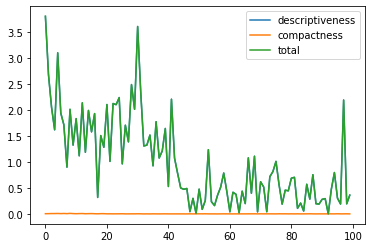

In [26]:
plt.plot(des_loss_list, label = 'descriptiveness')
plt.plot(com_loss_list, label = 'compactness')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()


# fine-tuning

In [27]:
related_model.trainable = True 
target_model.trainable = True 
related_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
target_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
@tf.function
def update_model(batch_traget_x, batch_related_x,  batch_related_y):

    with tf.GradientTape() as m_tape:
        
        output_related = related_model(batch_related_x, training = True)
        output_target = target_model(batch_traget_x, training = True)
        
        des_loss = descriptiveness_loss(batch_related_y, output_related)
        com_loss = compactness_loss(num_class, output_target)  
        total_loss =  des_loss + com_loss_weight * com_loss

    m_grads = m_tape.gradient(total_loss, related_model.trainable_variables)
    m_optimizer.apply_gradients(zip(m_grads, related_model.trainable_variables))
    
    return des_loss, com_loss, total_loss


In [30]:
base_lr = 1e-6
max_lr = 1e-5
layer_num = 0
inputs = target_model

In [31]:
epochs = 60

pre_loss = 0
des_loss_list = []
com_loss_list = []
total_loss_list = []

for epoch in range(epochs):
    start = time.time()



    des_loss_avg = tf.metrics.Mean()
    com_loss_avg = tf.metrics.Mean()
    total_loss_avg = tf.metrics.Mean()

    for batch_traget_x ,(batch_related_x,  batch_related_y ) in zip(target_dataset, reference_dataset):


        des_loss, com_loss, total_loss = update_model(batch_traget_x, batch_related_x,  batch_related_y)
        des_loss_avg(des_loss)
        com_loss_avg(com_loss)
        total_loss_avg(total_loss)
     
    des_loss_list.append(des_loss)
    com_loss_list.append(com_loss)
    total_loss_list.append(total_loss)
    
    if abs(pre_loss - total_loss) < 1e-8:
        break
    pre_loss  = total_loss

    if epoch % 1 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  DES_LOSS: {:.4f} COM_LOSS: {:.8f} TOTAL_LOSS: {:.4f}'.format(epoch, 
                                    epoch_time, des_loss_avg.result(),com_loss_avg.result(),total_loss_avg.result()))

   0: TIME: 22.19  DES_LOSS: 32.8479 COM_LOSS: 1.00664580 TOTAL_LOSS: 33.3513
   1: TIME: 18.80  DES_LOSS: 4.5094 COM_LOSS: 0.00009839 TOTAL_LOSS: 4.5094
   2: TIME: 18.92  DES_LOSS: 4.3814 COM_LOSS: 0.00011309 TOTAL_LOSS: 4.3814
   3: TIME: 18.64  DES_LOSS: 4.3311 COM_LOSS: 0.00014941 TOTAL_LOSS: 4.3312
   4: TIME: 18.74  DES_LOSS: 4.3218 COM_LOSS: 0.00006518 TOTAL_LOSS: 4.3218
   5: TIME: 18.58  DES_LOSS: 4.3113 COM_LOSS: 0.00006343 TOTAL_LOSS: 4.3113
   6: TIME: 18.86  DES_LOSS: 4.2936 COM_LOSS: 0.00006008 TOTAL_LOSS: 4.2937
   7: TIME: 19.00  DES_LOSS: 4.3387 COM_LOSS: 0.00006372 TOTAL_LOSS: 4.3387
   8: TIME: 18.68  DES_LOSS: 4.2530 COM_LOSS: 0.00006423 TOTAL_LOSS: 4.2530
   9: TIME: 18.73  DES_LOSS: 4.3222 COM_LOSS: 0.00006274 TOTAL_LOSS: 4.3222
  10: TIME: 18.71  DES_LOSS: 4.3016 COM_LOSS: 0.00006436 TOTAL_LOSS: 4.3017
  11: TIME: 18.88  DES_LOSS: 4.3004 COM_LOSS: 0.00006538 TOTAL_LOSS: 4.3005
  12: TIME: 18.80  DES_LOSS: 4.2401 COM_LOSS: 0.00006454 TOTAL_LOSS: 4.2401
  13: TIME

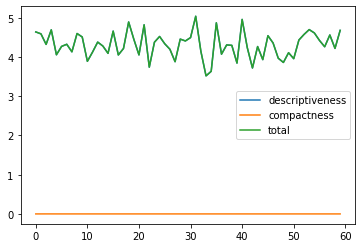

In [178]:
plt.plot(des_loss_list, label = 'descriptiveness')
plt.plot(com_loss_list, label = 'compactness')
plt.plot(total_loss_list, label = 'total')
plt.legend()
plt.show()


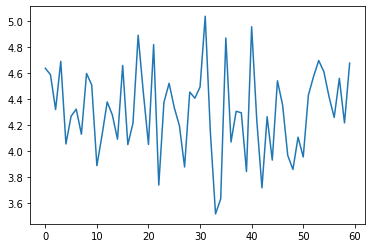

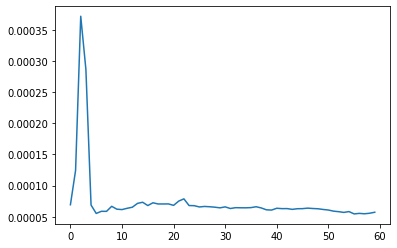

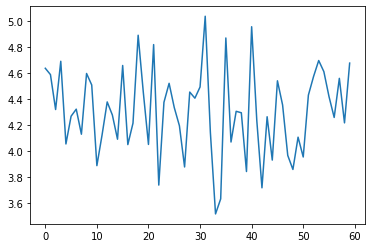

In [32]:
plt.plot(des_loss_list)
plt.show()
plt.plot(com_loss_list)
plt.show()
plt.plot(total_loss_list)
plt.show()

# 利用feature extraction 當input加入SVDD

## 參數設定

In [107]:
img_size = 224
flatten_size = 7* 7 * 512
n_samples = len(Tdata_train)
z_dim = 28
h_dim = [8, 4]
regular = 1e-5
max_lr = 1e-6
base_lr = 1e-4

n_epochs = 50
n_ae_epochs = 100
objective = 'soft-boundary'     #'one-class'  'soft-boundary'
nu = 0.1
warm_up_n_epochs = 10
optimizer = tf.keras.optimizers.Adam(lr = base_lr)
optimizer = tf.keras.optimizers.Adam(lr = base_lr)

## 整理generate data 當作encoder input

In [108]:
def make_generate_model(model):
    
    model.trainable = False
    layer_name = 'block5_pool'
    x = model.get_layer(layer_name).output
    output = tf.reshape(x, shape = (-1, flatten_size))
    g_model = tf.keras.Model(inputs=model.input, outputs = output)
    
    return g_model
generate = make_generate_model(target_model)
generate.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

## 建構模型

In [109]:


def make_encoder():

    inputs = tf.keras.Input(shape=(flatten_size,), name='inputs')
    x = tf.reshape(inputs, shape = (-1, 28, 28, 32))
    x = tf.keras.layers.Conv2D(h_dim[0], (5, 5), activation='linear', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)
    print(x.shape)
    x = tf.keras.layers.Conv2D(h_dim[1], (5, 5), activation='linear', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)
    print(x.shape)
    _, h, _, _ = x.shape
    x = tf.reshape(x, shape = (-1, h * h * h_dim[1]))
    x = tf.keras.layers.Dense(z_dim)(x)
    print(x.shape)
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    
   
def make_decoder():

    inputs = tf.keras.Input(shape=(z_dim,), name='inputs')
    x = tf.keras.layers.Dense(h_dim[1] * 7 * 7)(inputs)
    x = tf.reshape(x, shape = (-1, 7, 7, h_dim[1]))
    x = tf.keras.layers.LeakyReLU()(x)
    #x = tf.keras.layers.UpSampling2D((2, 2))(x)    
    
    x = tf.keras.layers.Conv2DTranspose(h_dim[1], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)   
    print(x.shape)
        
    x = tf.keras.layers.Conv2DTranspose(h_dim[0], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x) 
    print(x.shape)
    
    x = tf.keras.layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    print(x.shape)
    
    x = tf.reshape(x, shape = (-1, flatten_size))
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    

encoder = make_encoder()
encoder.summary()

(None, 14, 14, 8)
(None, 7, 7, 4)
(None, 28)
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 25088)]           0         
_________________________________________________________________
tf_op_layer_Reshape_21 (Tens [(None, 28, 28, 32)]      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 8)         6408      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_9 (Con

In [110]:
   def make_decoder():

    inputs = tf.keras.Input(shape=(z_dim,), name='inputs')
    x = tf.keras.layers.Dense(h_dim[1] * 7 * 7)(inputs)
    x = tf.reshape(x, shape = (-1, 7, 7, h_dim[1]))
    x = tf.keras.layers.LeakyReLU()(x)
    #x = tf.keras.layers.UpSampling2D((2, 2))(x)    
    
    x = tf.keras.layers.Conv2DTranspose(h_dim[1], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)   
    print(x.shape)
        
    x = tf.keras.layers.Conv2DTranspose(h_dim[0], (5, 5), padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x) 
    print(x.shape)
    
    x = tf.keras.layers.Conv2DTranspose(32, (5, 5), activation='sigmoid', padding='same', kernel_initializer='random_uniform', kernel_regularizer=tf.keras.regularizers.l2(regular))(x)
    print(x.shape)
    
    x = tf.reshape(x, shape = (-1, flatten_size))
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model    
decoder = make_decoder()
decoder.summary()

(None, 14, 14, 4)
(None, 28, 28, 8)
(None, 28, 28, 32)
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 196)               5684      
_________________________________________________________________
tf_op_layer_Reshape_23 (Tens [(None, 7, 7, 4)]         0         
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 7, 7, 4)           404       
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 4)           16        
_________________________________________________________________
lea

In [111]:

def get_radius(dist, nu):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return tfp.stats.percentile(tf.sqrt(dist), 1 - nu)

def init_center_c(eps = 0.1):
    
    positive = tf.fill([z_dim], eps)
    negative = tf.fill([z_dim], -eps)
    c = tf.zeros(shape = [z_dim], dtype = tf.float32, name = 'c')
    n_sample = 0
    for batch, (batch_x) in enumerate(target_dataset):
        center= tf.reduce_sum(encoder(generate(batch_x, training = False), training = False), axis = 0, name = 'outputs')
        c = c +center
        n_sample = n_sample + batch_x.shape[0]
    c = c/n_sample
    # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.

    c = tf.where(tf.logical_and(tf.less(c, 0), tf.greater(c, -eps)), negative, c)
    c = tf.where(tf.logical_and(tf.greater(c, 0), tf.less(c, eps)), positive, c)
    return c


@tf.function
def train_ae_model(batch_x):
    with tf.GradientTape() as ae_tape:
        generate_output = generate(batch_x, training =False)
        ae_output = decoder(encoder(generate_output, training=True), training=True)
        loss = tf.reduce_mean((ae_output - generate_output) ** 2)

    grads = ae_tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

    return loss

@tf.function
def train_model(batch_x, c, R, objective):
    with tf.GradientTape() as tape:
        generate_output = generate(batch_x, training =False)
        output = encoder(generate_output, training=True)
        dist = tf.reduce_sum((output - c) ** 2, 1)
      
        if objective == 'soft-boundary':
            scores = dist - R ** 2
            output_loss = R ** 2 + (1 / nu) * tf.reduce_mean(tf.maximum(tf.zeros_like(scores), scores))
        else:
            output_loss = tf.reduce_mean(dist)

    grads = tape.gradient(output_loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables))

    return output_loss, dist

## Prtrain

In [112]:
global_step = 0  
step_size = 2 * np.ceil(n_samples / batch_size)

for epoch in range(n_ae_epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    epoch_ae_loss_avg = tf.metrics.Mean()
    
    for batch, (batch_x) in enumerate(target_dataset):
         # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)

        optimizer.lr = clr
        ae_loss = train_ae_model(batch_x)
        
        epoch_ae_loss_avg(ae_loss)
        
    if epoch % 10 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  LOSS: {:.4f} '.format(epoch, epoch_time, epoch_ae_loss_avg.result()))




   0: TIME: 4.10  LOSS: 0.3587 
  10: TIME: 2.87  LOSS: 0.1912 
  20: TIME: 2.78  LOSS: 0.1583 
  30: TIME: 2.80  LOSS: 0.1489 
  40: TIME: 2.77  LOSS: 0.1447 
  50: TIME: 2.81  LOSS: 0.1406 
learning rate changed!
  60: TIME: 2.79  LOSS: 0.1358 
  70: TIME: 2.81  LOSS: 0.1339 
  80: TIME: 2.76  LOSS: 0.1323 
  90: TIME: 2.77  LOSS: 0.1311 


## Train

   0: TIME: 3.36  LOSS: 0.3296 
  10: TIME: 2.73  LOSS: 0.0222 
  20: TIME: 2.85  LOSS: 0.0118 
  30: TIME: 2.78  LOSS: 0.0074 
  40: TIME: 2.73  LOSS: 0.0075 


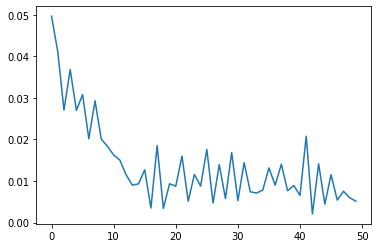

In [113]:
R = tf.zeros(shape = [1], dtype = tf.float32, name = 'R')
c = init_center_c(eps = 0.1)

pre_loss = 0
loss_list = []

for epoch in range(n_epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    epoch_loss_avg = tf.metrics.Mean()    
   
    for batch, (batch_x) in enumerate(target_dataset):

        # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)

        optimizer.lr = clr
        loss_, dist = train_model(batch_x, c, R, objective)
        
        epoch_loss_avg(loss_)

    if (objective == 'soft-boundary') and (epoch >= warm_up_n_epochs):
        R = get_radius(dist, nu)
        
    loss_list.append(loss_)
    if abs(pre_loss - loss_) < 1e-8:
        break
    pre_loss = loss_

    if epoch % 10 == 0:
        epoch_time = time.time() - start
        print('{:4d}: TIME: {:.2f}  LOSS: {:.4f} '.format(epoch, epoch_time, epoch_loss_avg.result()))

plt.plot(loss_list)
plt.show()


In [127]:
def dist(target_dataset, center):
    i = 0
    for batch, (batch_x) in enumerate(target_dataset):
        
        generate_output = generate(batch_x, training =False)
        output = encoder(generate_output, training=True)
        distance = tf.reduce_sum(tf.square(output - center), 1) 
        if i==0:
            distances=distance
        else:
            distances = tf.concat([distances, distance], 0) 
        i = i + 1
    dis = distances.numpy() 
    plt.hist(dis, rwidth=0.3, color='b')
    plt.show()

    return distances

In [148]:
def threshold(data, dists):
    dict_score = {}
    for i in range(len(dists)):
        dict_score[float(dists[i])] = i
    sort_score = [(k, dict_score[k]) for k in sorted(dict_score.keys())]
    
    n_digits = 15  # how many digits we will display
    fig = plt.figure(figsize=(20, 4))
    for i in range(1, n_digits):
        # display normal
        ax = plt.subplot(2, n_digits, i + 1)
        plt.imshow(data[sort_score[i][1]].reshape(img_size, img_size,3), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display anomaly
        ax = plt.subplot(2, n_digits, i + 1 + n_digits)
        plt.imshow(data[sort_score[-i][1]].reshape(img_size, img_size,3), cmap = plt.cm.gray)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


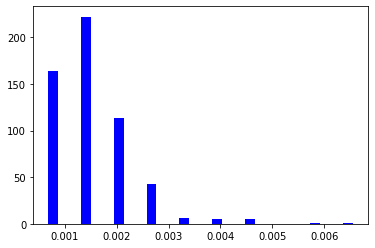

In [129]:
dists = dist(target_dataset, c)

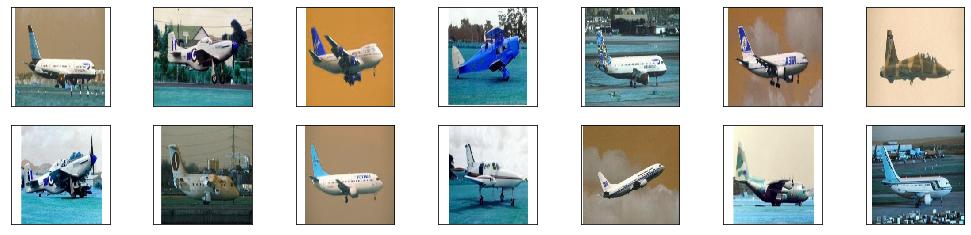

In [132]:
img_size = 224
threshold(Tdata_train, dists)

## 測試用的資料

In [153]:
target_test_x = np.vstack((Rdata_test,Tdata_test))
target_test_y = [0] * len(Rdata_test) + [1] * len(Tdata_test)
target_test_x = np.array(target_test_x)
target_test_y = np.array(target_test_y)

In [154]:
idx = np.random.permutation(len(target_test_x))
target_test_x, target_test_y = target_test_x[idx], target_test_y[idx]

In [155]:
y_true = []
y_scores = []
result_test = np.zeros([2, len(target_test_x)]) 
for i in range(len(target_test_x)):
    
    genrate_output = generate(tf.expand_dims(target_test_x[i],0), training =False)
    dist = tf.reduce_sum(tf.square(encoder(genrate_output, training=False) - c), 1)
    
    if objective == 'soft-boundary':
        scores = dist - R ** 2
    else:
        scores = dist
        
    result_test[0, i] = target_test_y[i]
    result_test[1, i] = 1/scores
    y_true.append(result_test[0, i])
    y_scores.append(result_test[1, i])

In [156]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_true, y_scores)
print('AUC:', test_auc)

AUC: 0.8923755324813631


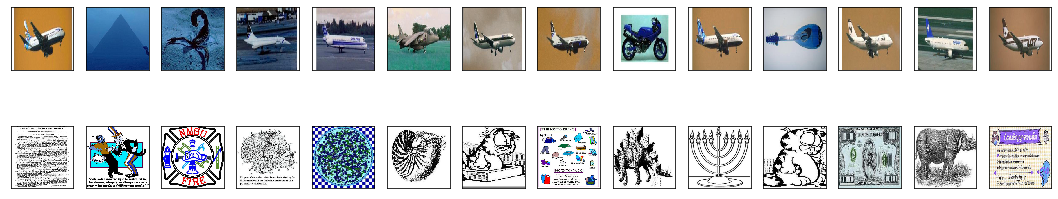

In [157]:
threshold(target_test_x, y_scores)

In [167]:
y_true = np.array(y_true)
y_scores = np.array(y_scores)

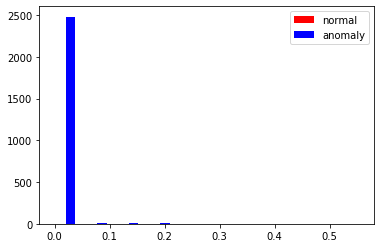

In [176]:
plt.hist(y_scores[y_true==1.], rwidth = 0.3, color = 'r',label = 'normal')
plt.hist(y_scores[y_true==0.], rwidth = 0.3, color = 'b',label = 'anomaly')
plt.legend()
plt.show()

(array([50., 70., 57., 33., 10.,  9.,  6.,  4.,  0.,  1.]),
 array([-4.74951230e-06,  4.26634611e-04,  8.58018734e-04,  1.28940286e-03,
         1.72078698e-03,  2.15217110e-03,  2.58355523e-03,  3.01493935e-03,
         3.44632347e-03,  3.87770759e-03,  4.30909172e-03]),
 <a list of 10 Patch objects>)

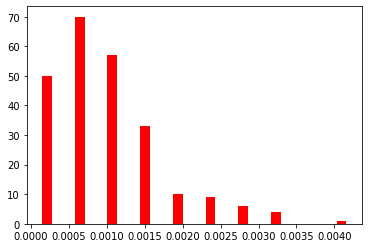

In [173]:
plt.hist(y_scores[y_true==1.], rwidth = 0.3, color = 'r',label = 'normal')

(array([2.481e+03, 1.400e+01, 4.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([7.68842292e-05, 5.74099906e-02, 1.14743097e-01, 1.72076203e-01,
        2.29409310e-01, 2.86742416e-01, 3.44075523e-01, 4.01408629e-01,
        4.58741735e-01, 5.16074842e-01, 5.73407948e-01]),
 <a list of 10 Patch objects>)

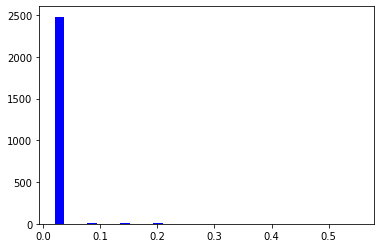

In [174]:
plt.hist(y_scores[y_true==0.], rwidth = 0.3, color = 'b',label = 'anomaly')
